# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

I will use the GARCH model to simulate a non-constant volatility.
### 1. GARCH (Generalized Autoregressive Conditional Heteroskedasticity)

**Purpose**: Models volatility that changes over time, capturing **volatility clustering** (i.e., large changes tend to be followed by large changes).

The **GARCH(1,1)** model is the most common variant:

$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

where:

- $\sigma_t^2$: conditional variance at time $t$  
- $\epsilon_{t-1}^2$: squared return shock from the previous period  
- $\alpha_0$, $\alpha_1$, $\beta_1$: model parameters



In [2]:
def stock_path_garch(S0, t, r, mu, n_paths, n_steps, omega=0.04, alpha=0.1, beta=0.85):
    '''
    Simulates stock paths using geometric Brownian motion with time-varying
    volatility modeled by GARCH(1,1).

    Parameters:
    S0 (float): initial stock price
    t (float): total time in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of paths to simulate
    n_steps (int): number of steps per path
    omega, alpha, beta (float): GARCH(1,1) parameters

    Returns:
    numpy.ndarray: Simulated stock paths (n_paths x (n_steps + 1))
    '''

    dt = t / n_steps
    log_returns = np.zeros((n_paths, n_steps))
    sigma2 = np.full((n_paths, n_steps), 0.04)  # initial variance = 0.2^2
    shocks = np.zeros((n_paths, n_steps))

    for i in range(1, n_steps):
        # Generate white noise
        z = np.random.normal(size=n_paths)
        
        # Update volatility using GARCH(1,1)
        sigma2[:, i] = omega + alpha * shocks[:, i-1]**2 + beta * sigma2[:, i-1]
        sigma = np.sqrt(sigma2[:, i])
        
        # Generate log-return increment
        shocks[:, i] = sigma * np.sqrt(dt) * z
        log_returns[:, i] = (mu + r - 0.5 * sigma2[:, i]) * dt + shocks[:, i]

    # Cumulative log-returns
    cumulative_returns = np.cumsum(log_returns, axis=1)

    # Generate stock price paths
    paths = S0 * np.exp(cumulative_returns)
    paths = np.insert(paths, 0, S0, axis=1)  # Insert initial price at t=0

    return paths

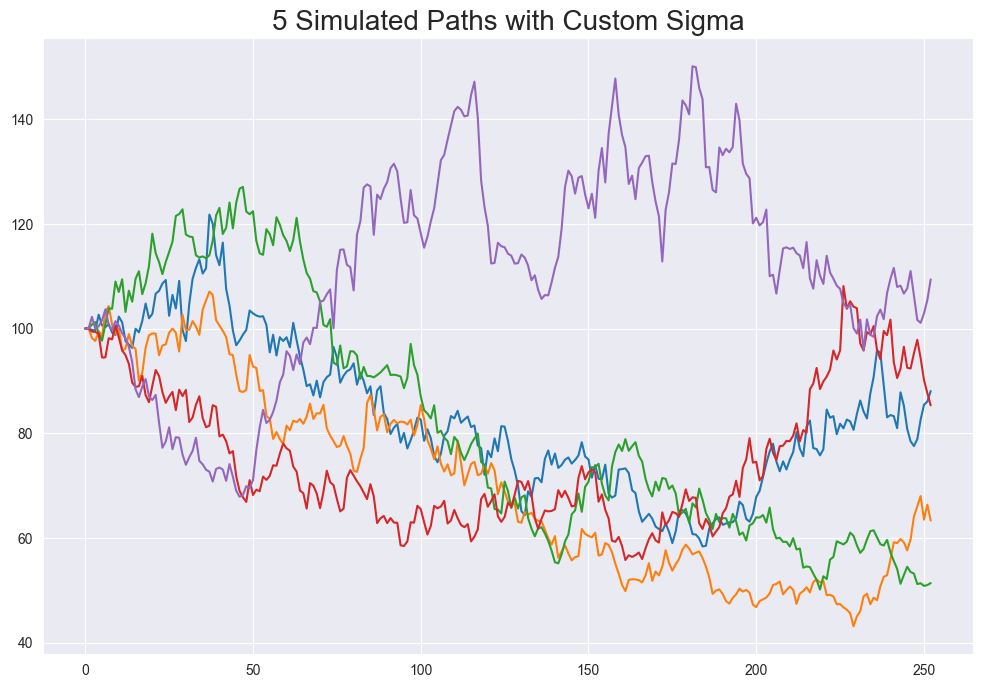

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_garch(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [4]:
def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

In [5]:
def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price

In [6]:
def bs_MC_call_garch(S0, K, r, t, mu=0, n_sims=2500, n_hedges=50,
                     omega=0.0001, alpha=0.1, beta=0.85, sigma0=0.2):
    """
    Monte Carlo simulation of a call option value using Black-Scholes model
    with GARCH(1,1) time-varying volatility and delta hedging.
    """
    dt = t / n_hedges
    noise = np.random.normal(0, 1, (n_sims, n_hedges))

    # Initialize arrays
    log_returns = np.zeros((n_sims, n_hedges))
    sigma2 = np.full((n_sims, n_hedges), sigma0**2)
    shocks = np.zeros((n_sims, n_hedges))
    
    # Simulate GARCH volatility and stock price paths
    for i in range(1, n_hedges):
        # Update GARCH variance
        sigma2[:, i] = omega + alpha * shocks[:, i-1]**2 + beta * sigma2[:, i-1]
        sigma = np.sqrt(sigma2[:, i])
        shocks[:, i] = sigma * np.sqrt(dt) * noise[:, i]
        drift = (mu + r - 0.5 * sigma2[:, i]) * dt
        log_returns[:, i] = drift + shocks[:, i]

    # Stock price paths
    cum_log_returns = np.cumsum(log_returns, axis=1)
    paths = S0 * np.exp(cum_log_returns)

    # Call payouts at maturity
    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    # Delta-hedging simulation
    stock_profits = []

    # Initial hedge
    sigma_start = np.sqrt(sigma2[:, 1])  # time step 1 sigma (first actual simulated)
    delta_start = bs_call_delta(S0, K, sigma_start, t, r)
    paths_first = paths[:, 0]
    profit_0 = (paths_first - S0 * np.exp(r * dt)) * delta_start * np.exp(-r * dt)
    stock_profits.append(profit_0)

    # Remaining hedging steps
    for i in range(1, n_hedges):
        stock_start = paths[:, i - 1]
        stock_end = paths[:, i]
        tte = t - i * dt
        sigma_t = np.sqrt(sigma2[:, i])
        delta_i = bs_call_delta(stock_start, K, sigma_t, tte, r)
        profit_i = (stock_end - stock_start * np.exp(r * dt)) * delta_i * np.exp(-r * dt * i)
        stock_profits.append(profit_i)

    # Hedged profit
    total_hedge_profit = np.sum(stock_profits, axis=0)
    profits_hedged = call_payouts - total_hedge_profit

    return profits_hedged

In [7]:
def bs_MC_call_garch_deltahedge(S0, K, r, t, omega, alpha, beta,
                                 sigma0=0.2, mu=0.0, n_sims=2500, n_hedges=50):
    """
    Monte Carlo simulation of a Black-Scholes call option payout
    with GARCH(1,1) volatility and delta hedging at each timestep.
    
    Returns:
        Array of final hedged profits (payout - hedging costs)
    """
    dt = t / n_hedges
    paths = np.zeros((n_sims, n_hedges))
    sigma2 = np.zeros((n_sims, n_hedges))
    epsilons = np.zeros((n_sims, n_hedges))

    # Initialization
    paths[:, 0] = S0
    sigma2[:, 0] = sigma0**2

    for i in range(1, n_hedges):
        z = np.random.normal(0, 1, n_sims)
        epsilons[:, i - 1] = np.sqrt(sigma2[:, i - 1]) * z
        sigma2[:, i] = omega + alpha * epsilons[:, i - 1]**2 + beta * sigma2[:, i - 1]

        log_returns = (mu - 0.5 * sigma2[:, i]) * dt + np.sqrt(sigma2[:, i]) * np.sqrt(dt) * z
        paths[:, i] = paths[:, i - 1] * np.exp(log_returns)

    # Final option payoff
    S_T = paths[:, -1]
    call_payoff = np.maximum(S_T - K, 0)
    discounted_payoff = call_payoff * np.exp(-r * t)

    # Track hedging P&L
    hedge_profits = np.zeros(n_sims)

    for i in range(1, n_hedges):
        S_start = paths[:, i - 1]
        S_end = paths[:, i]
        sigma_t = np.sqrt(sigma2[:, i])
        tte = t - i * dt  # time to expiry

        # Avoid division by zero near expiration
        tte = np.maximum(tte, 1e-8)

        deltas = bs_call_delta(S_start, K, sigma_t, tte, r)

        # Cost of holding delta hedge
        hedge_profit = (S_end - S_start * np.exp(r * dt)) * deltas * np.exp(-r * i * dt)
        hedge_profits += hedge_profit

    # Final hedged profit: option payoff minus hedging costs
    profits_hedged = discounted_payoff - hedge_profits

    return profits_hedged

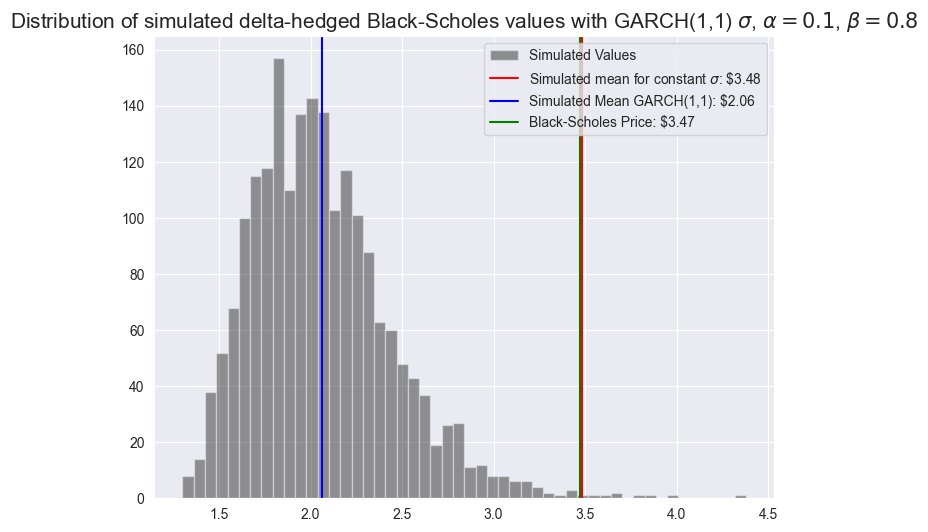

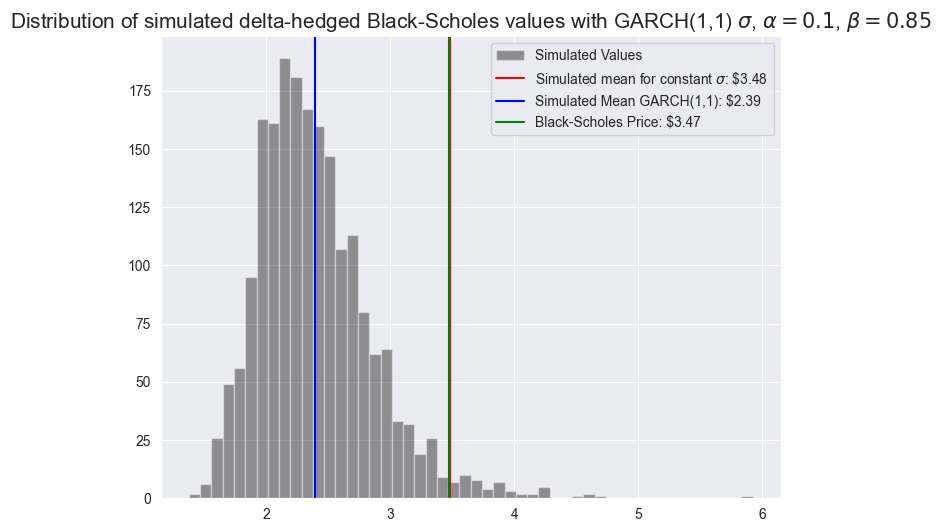

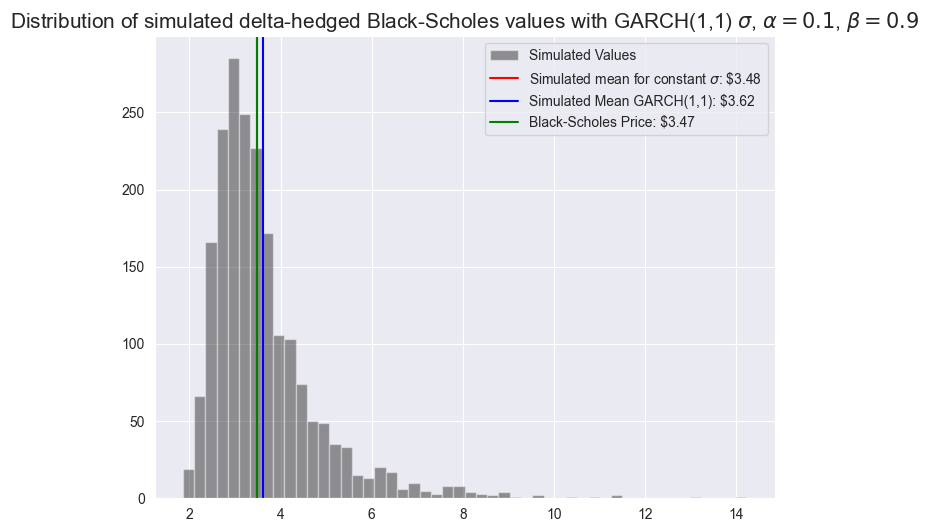

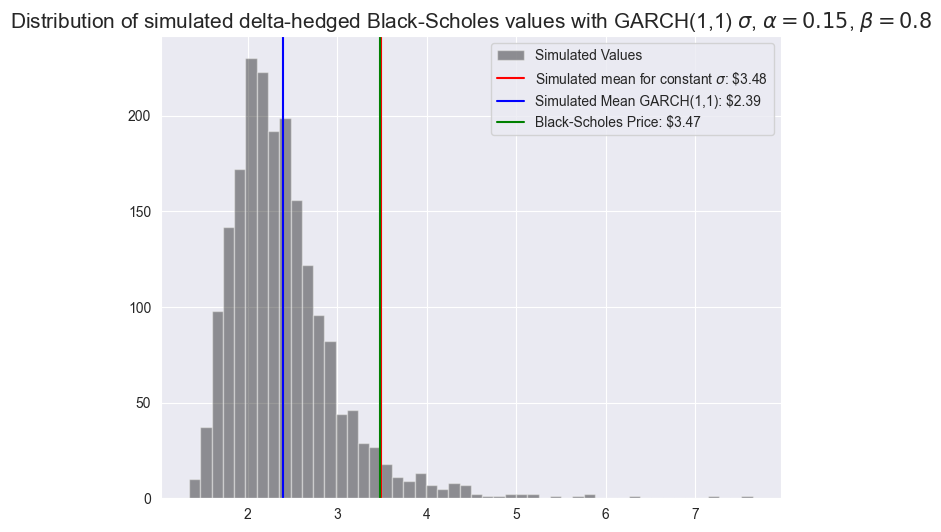

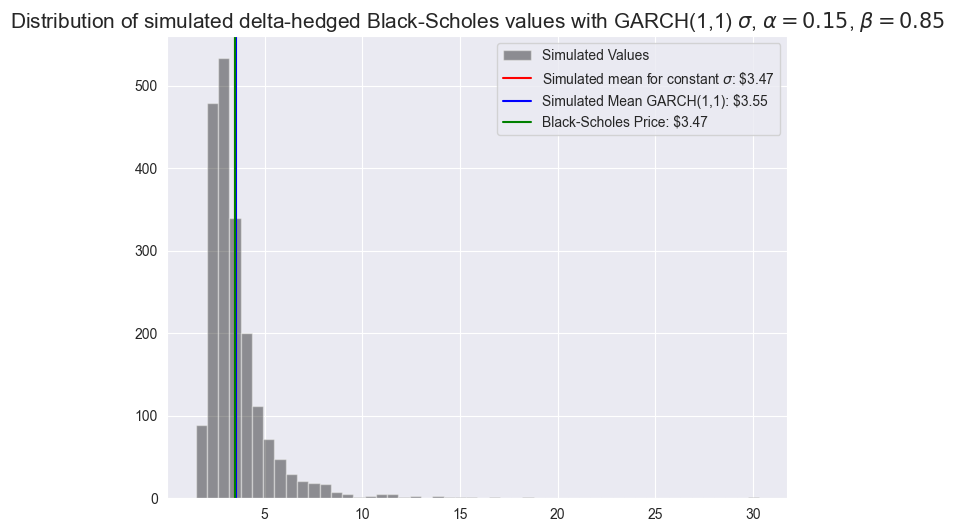

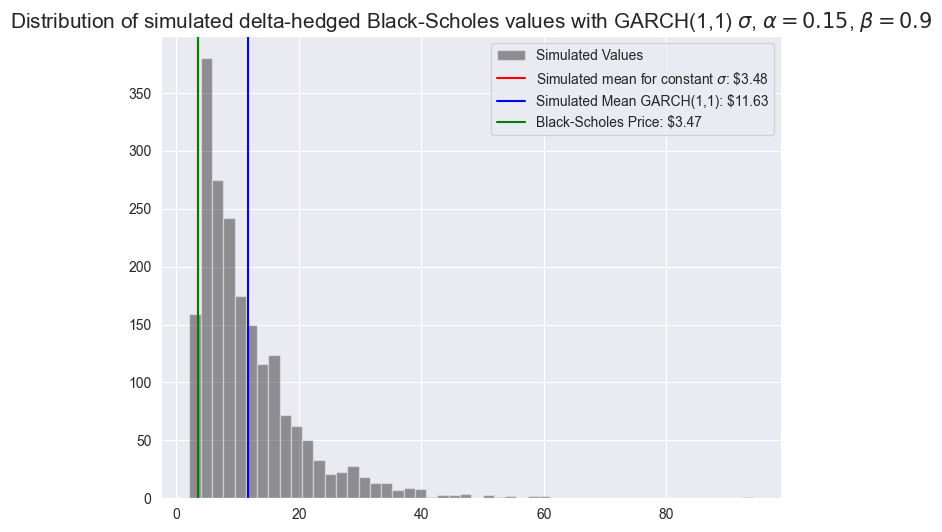

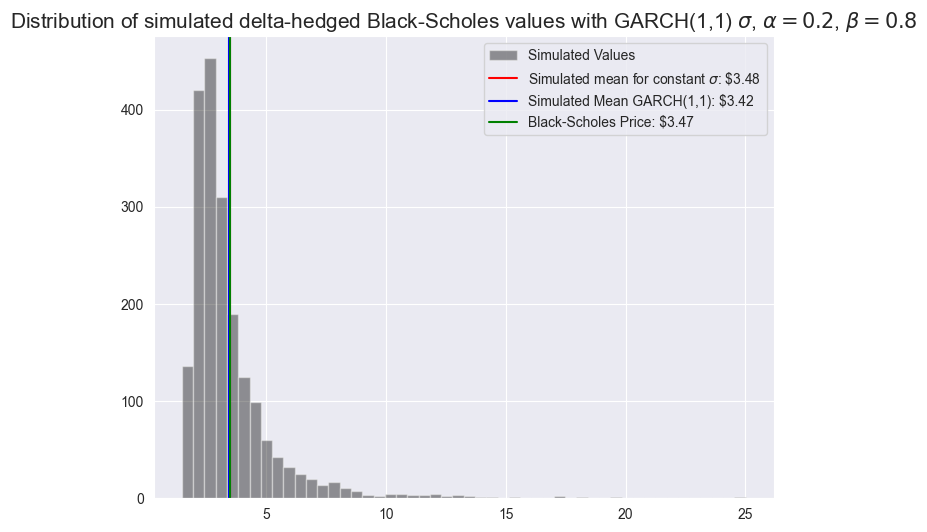

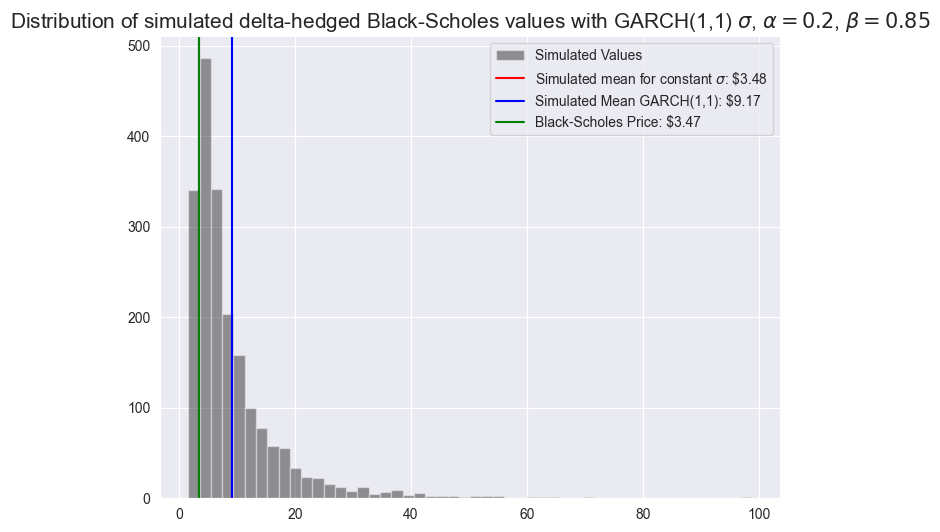

C:\Users\korodi.9\AppData\Local\Temp\ipykernel_15416\544943381.py:16: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))


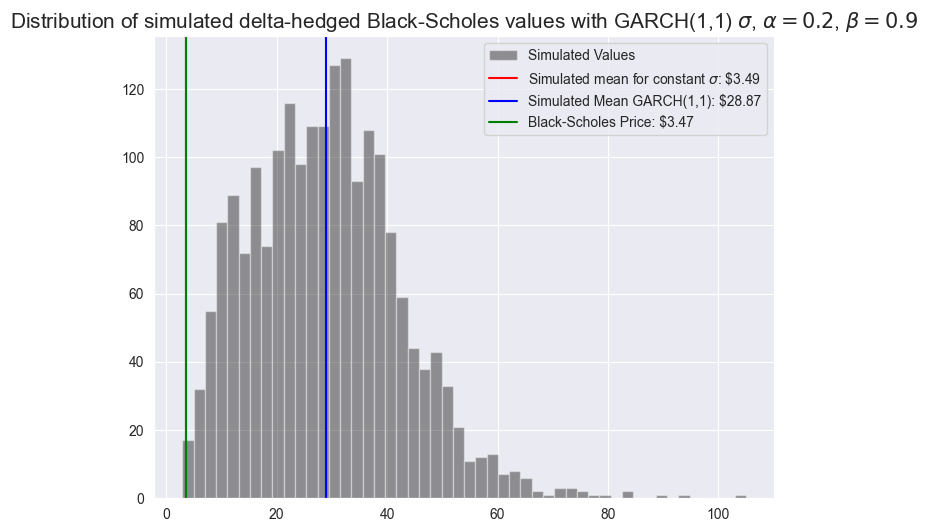

In [8]:
#Test Function and create histograms of simulated values

S0 = 35
K = 35
sigma0 = .2
#omega = sigma0**2
omega = 0.0001
t = 1
r = 0.04
mu = .35 #Drift of stock movement
n_hedges=100
n_sims = 2000

alphas=[0.1,0.15,0.2] #some different model parameters
betas=[0.8,0.85,0.9]


for alpha in alphas:
    for beta in betas:
        #profits_hedged = bs_MC_call_garch(S0, K, r, t, mu, n_sims, n_hedges, omega, alpha, beta, sigma0)
        profits_hedged =bs_MC_call_garch_deltahedge(S0, K, r, t, omega, alpha, beta,
                                 sigma0, mu, n_sims, n_hedges)
        profits_hedged_sigma0 = bs_MC_call_garch(S0, K, r, t, mu, n_sims, n_hedges, 0, 0, 1, sigma0)
        bs_price=bs_call(S0,K,sigma0,t,r)
    
    
        plt.figure(figsize = (8,6))
    
        plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
    
        plt.axvline(np.mean(profits_hedged_sigma0), label = rf'Simulated mean for constant $\sigma$: \${np.mean(profits_hedged_sigma0):.2f}', color = 'red')
    
        plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean GARCH(1,1): ${np.mean(profits_hedged):.2f}', color = 'blue')

        plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'green')
        
        plt.legend()
    
        plt.title(rf'Distribution of simulated delta-hedged Black-Scholes values with GARCH(1,1) $\sigma$, $\alpha={alpha}$, $\beta={beta}$',size=15)
    
        plt.show()

The increased volatility in the GARCH(1,1) model causes the BS value of call options to go up. The larger the alpha and beta parameters, the more the price goes up. If we are selling call options at BS price assuming a constant volatility, the non-contant volatility could result in us losing money. 

We can hedge agains the non-constant volatility by doing sigma-hedging (also called vega-hedging). 
Vega measures the sensitivity of an option's price to changes in the volatility of the underlying asset:

$$
\text{Vega} = \frac{\partial C}{\partial \sigma}
$$

In the Black-Scholes model, the vega of both call and put options is given by:

$$
\text{Vega} = S \cdot \phi(d_1) \cdot \sqrt{T}
$$

Where:

- \( S \) is the spot price of the underlying asset  
- \( T \) is the time to expiration (in years)  
- \($ \phi(d_1)$ \) is the standard normal probability density function evaluated at \( $d_1$ \)

And:

$$
d_1 = \frac{\ln(S/K) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}
$$

Vega hedging:
- We sold a call option.
- If the volatility increases we would lose money.
- We buy another asset (another call option in my example) to neutralize the vega of our portfolio.
    1. Compute the **Black-Scholes vega** of the **main option**:

    $$
    \text{vega}_{\text{main}} = S_t \cdot \phi(d_1) \cdot \sqrt{\tau}
    $$

    where $\tau = T - t$ and $\phi$ is the standard normal PDF.

    2. Compute the **vega of the hedge option**, which has a **different strike $K_{\text{hedge}}$**:

    $$
    \text{vega}_{\text{hedge}} = S_t \cdot \phi(d_1^{\text{hedge}}) \cdot \sqrt{\tau}
    $$

    3. Calculate the **hedge ratio**:

    $$
    \text{hedge ratio} = \frac{\text{vega}_{\text{main}}}{\text{vega}_{\text{hedge}}}
    $$

    4. At each timestep, we adjust our hedge position so that our portfolio holds hedge_ratio amount of the hedge option per unit of the main option.

### 💸 P&L from the Hedge:

- The **hedge option's price change** due to $\Delta \sigma$ is approximated as:

$$
\Delta V_{\text{hedge}} \approx \text{vega}_{\text{hedge}} \cdot \Delta \sigma
$$

- The **hedging profit** at this time step is:

$$
\text{profit} = \text{hedge ratio} \cdot \Delta V_{\text{hedge}}
$$

- The profit is **discounted** to time zero:

$$
\text{profit}_t \cdot e^{-r \cdot t}
$$

- All such profits are **accumulated over time** to calculate the total hedge P&L.
 

In [9]:
# Black-Scholes Vega
def bs_call_vega(S, K, sigma, t, r):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    return S * norm.pdf(d1) * np.sqrt(t)

In [10]:
def bs_MC_vega_hedge_garch(
    S0, K, K_hedge, r, t, omega, alpha, beta,
    sigma0=0.2, mu=0.0, n_sims=2500, n_hedges=50
):
    """
    Monte Carlo simulation of a Black-Scholes call option with vega hedging.
    Volatility follows a GARCH(1,1) model.
    Hedge is done using an option with a different strike (K_hedge).
    """

    dt = t / n_hedges
    paths = np.zeros((n_sims, n_hedges))
    sigma2 = np.zeros((n_sims, n_hedges))
    epsilons = np.zeros((n_sims, n_hedges))

    paths[:, 0] = S0
    sigma2[:, 0] = sigma0**2

    for i in range(1, n_hedges):
        z = np.random.normal(0, 1, n_sims)
        epsilons[:, i - 1] = np.sqrt(sigma2[:, i - 1]) * z
        sigma2[:, i] = omega + alpha * epsilons[:, i - 1]**2 + beta * sigma2[:, i - 1]

        log_returns = (mu - 0.5 * sigma2[:, i]) * dt + np.sqrt(sigma2[:, i]) * np.sqrt(dt) * z
        paths[:, i] = paths[:, i - 1] * np.exp(log_returns)

    # Final payoff of the main option
    S_T = paths[:, -1]
    call_payoffs = np.maximum(S_T - K, 0) * np.exp(-r * t)

    # Vega hedging P&L using hedge option with different K
    hedge_profits = np.zeros(n_sims)

    for i in range(1, n_hedges):
        tte = t - i * dt
        if tte <= 0:
            continue

        S_t = paths[:, i]
        sigma_t = np.sqrt(sigma2[:, i])

        # Compute vegas
        vega_main = bs_call_vega(S_t, K, sigma_t, tte, r)
        vega_hedge = bs_call_vega(S_t, K_hedge, sigma_t, tte, r)

        # Avoid divide-by-zero
        hedge_ratio = np.divide(vega_main, vega_hedge + 1e-8)

        # Volatility change
        d_sigma = sigma_t - np.sqrt(sigma2[:, i - 1])

        # Hedge value change
        d_hedge_val = vega_hedge * d_sigma

        # Hedging profit per step
        step_profit = hedge_ratio * d_hedge_val * np.exp(-r * i * dt)
        hedge_profits += step_profit

    # Final result: hedged profit
    profits_hedged = call_payoffs - hedge_profits
    return profits_hedged

In [11]:
def bs_MC_call_garch_nohedge(S0, K, r, t, omega, alpha, beta,
                     sigma0=0.2, mu=0.0, n_sims=2500, n_hedges=50):
    """
    Monte Carlo simulation of a Black-Scholes call option payout 
    with volatility evolving via a GARCH(1,1) model.
    
    Parameters:
        S0: Initial stock price
        K: Strike price
        r: Risk-free interest rate
        t: Time to expiration
        omega, alpha, beta: GARCH(1,1) parameters
        sigma0: Initial volatility
        mu: Drift
        n_sims: Number of simulations
        n_hedges: Number of time steps
    
    Returns:
        Array of discounted call option payouts (no hedging)
    """
    dt = t / n_hedges
    paths = np.zeros((n_sims, n_hedges))
    sigma2 = np.zeros((n_sims, n_hedges))
    epsilons = np.zeros((n_sims, n_hedges))

    # Initialization
    paths[:, 0] = S0
    sigma2[:, 0] = sigma0**2

    for i in range(1, n_hedges):
        z = np.random.normal(0, 1, n_sims)
        epsilons[:, i - 1] = np.sqrt(sigma2[:, i - 1]) * z
        sigma2[:, i] = omega + alpha * epsilons[:, i - 1]**2 + beta * sigma2[:, i - 1]

        log_returns = (mu - 0.5 * sigma2[:, i]) * dt + np.sqrt(sigma2[:, i]) * np.sqrt(dt) * z
        paths[:, i] = paths[:, i - 1] * np.exp(log_returns)

    # Final asset price
    S_T = paths[:, -1]

    # Payoff
    call_payoff = np.maximum(S_T - K, 0)

    # Discounted payoff (present value)
    discounted_payoff = call_payoff * np.exp(-r * t)

    return discounted_payoff

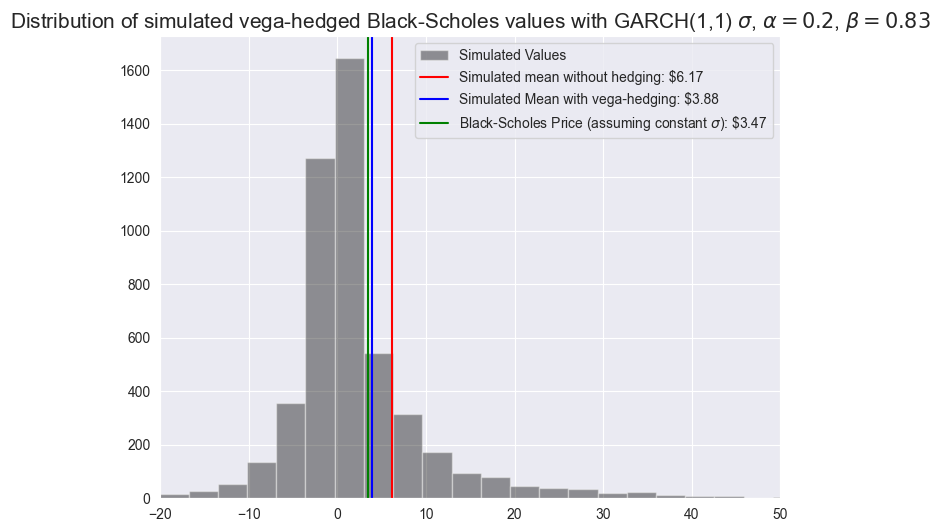

In [20]:
S0 = 35
K = 35
K_hedge = 40
sigma0 = .2
omega = 0.0001
t = 1
r = 0.04
mu = 0 #no drift for simplicity ()
n_hedges=100
n_sims = 5000

alpha=0.2
beta=0.83

profits_hedged = bs_MC_vega_hedge_garch(S0, K, K_hedge, r, t, omega, alpha, beta,
                           sigma0, mu, n_sims, n_hedges)
profits_nothedged = bs_MC_call_garch_nohedge(S0, K, r, t, omega, alpha, beta, sigma0, mu, n_sims, n_hedges)
bs_price=bs_call(S0,K,sigma0,t,r)
    
    
plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 500, alpha = .4, color = 'black', label = 'Simulated Values')

plt.xlim(-20, 50)
    
plt.axvline(np.mean(profits_nothedged), label = rf'Simulated mean without hedging: ${np.mean(profits_nothedged):.2f}', color = 'red')
    
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean with vega-hedging: ${np.mean(profits_hedged):.2f}', color = 'blue')

plt.axvline(bs_price, label=rf'Black-Scholes Price (assuming constant $\sigma$): \${bs_price:.2f}', color='green')
        
plt.legend()
    
plt.title(rf'Distribution of simulated vega-hedged Black-Scholes values with GARCH(1,1) $\sigma$, $\alpha={alpha}$, $\beta={beta}$',size=15)
    
plt.show()